In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

import string

In [2]:
df_decollete = pd.read_csv('Labelled_decollete_neckcream.csv',index_col=0)
# df_bb = pd.read_csv('Labelled_bb_cc_cream.csv',index_col=0)
# df_face = pd.read_csv('Labelled_face_oil.csv',index_col=0)
# df_mists = pd.read_csv('Labelled_mists_essences.csv',index_col=0)
# df_moisturizer = pd.read_csv('Labelled_moisturizer.csv',index_col=0)
# df_night = pd.read_csv('Labelled_night_cream.csv',index_col=0)

In [3]:
df_all_moisturizer = pd.read_csv('All Moisturizers Labelled.csv',index_col=0)

In [4]:
pd.set_option('display.max_columns', 50)
df_all_moisturizer

,item_id,total_reviews,user_name,skin_type,skin_tone,age_range,review_title,review,review_rating,not_helpful,helpful,free_product,recommend,review_time,category,no_of_reviews,multiple,title_and_review,brand,mentions,counts,fake
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,
0,1932201,580,zombified,Combination,Tan,NaN,you'll get hooked!,i've heard so many great things about this--t...,5,220,2278,0,1,7 Sep 2017,moisturizer,1.0,0,you'll get hooked! i've heard so many great th...,la mer,la mer,3.0,1
1,1932201,580,Stripper,Dry,Medium,NaN,good but not 170 dollars per ounce good,good? yes! 170 dollars per ounce good? not qu...,4,70,403,0,1,30 Apr 2018,moisturizer,1.0,0,good but not 170 dollars per ounce good good? ...,la mer,la mer,1.0,0
2,1932201,580,alephbet,Oily,Medium,35-44,unbelievable!,i have rosacea and had been using first aid s...,5,60,394,0,0,22 Mar 2017,moisturizer,1.0,0,unbelievable! i have rosacea and had been usin...,la mer,la mer,1.0,0
3,1932201,580,ShelbyWW,Combination,Medium,NaN,,got a free sample size and unfortunately it's...,5,38,367,0,1,12 Sep 2018,moisturizer,1.0,0,got a free sample size and unfortunately it'...,la mer,NaN,0.0,0
4,1932201,580,meshybelle,Combination,Medium,45-54,worth it.,pricey? you betcha! worth it? yup!! my skin h...,5,52,347,0,0,23 May 2017,moisturizer,1.0,0,worth it. pricey? you betcha! worth it? yup!! ...,la mer,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237294,1809235,51,Goldilocks55,Normal,Light,NaN,disappointed,i bought this because other reviews said it w...,1,2,0,0,0,16 Jul 2019,moisturizer,1.0,0,disappointed i bought this because other revie...,dr. dennis gross skincare,NaN,0.0,0
237295,1809235,51,SandyG19,Combination,Light,NaN,great tinted moisturizer with spf.,i really like this product for its spf proper...,4,0,0,0,1,25 Apr 2019,moisturizer,1.0,0,great tinted moisturizer with spf. i really li...,dr. dennis gross skincare,NaN,0.0,0
237296,1809235,51,ZeniZen,Combination,Tan,NaN,,this is great to layer over a tinted cream fo...,5,0,0,0,1,11 Oct 2017,moisturizer,1.0,0,this is great to layer over a tinted cream f...,dr. dennis gross skincare,NaN,0.0,0


# Feature Engineering

In [5]:
def add_features(df):
    
    # create a new column indicating whether the review has a title
    df['have_title'] = np.where(df['review_title']==' ',0,1)

    # create columns indicating the complexity of the review
    def complexity_score(review):
        num_chars=len(review)
        num_words=len(word_tokenize(review))
        num_sentences=len(sent_tokenize(review))
        vocab = {x.lower() for x in word_tokenize(review)}
        return num_words, (num_chars/num_words), (num_words/num_sentences), len(vocab)/num_words
    df['len_of_review'], df['avg_chars_per_word'] , df['avg_words_per_sentence'] , df['unique_vocab_percentage']  = zip(*df['review'].apply(complexity_score))

    # create a new column indicating whether the user has complete information (skin_type,skin_tone,age_range)
    df['skin_type'] = np.where(df['skin_type'].notnull(), 1, 0)
    df['skin_tone'] = np.where(df['skin_tone'].notnull(), 1, 0)
    df['age_range'] = np.where(df['age_range'].notnull(), 1, 0)
    df['information_integrity'] = df['skin_type'] + df['skin_tone'] + df['age_range']
    
    return df

In [6]:
def normalization(df, new_feature_df):
    
    # normalize all feature columns to 0-1
    min_max_scaler = preprocessing.MinMaxScaler()

    def normalize(column):
        x = df[[column]].values
        x_scaled = min_max_scaler.fit_transform(x)
        flattened_x = []
        for list_ in x_scaled:
            flattened_x.append(list_[0])
        return flattened_x

    new_feature_df['total_reviews'] = pd.Series(normalize('total_reviews'))
    new_feature_df['review_rating'] = pd.Series(normalize('review_rating'))
    new_feature_df['free_product'] = pd.Series(normalize('free_product'))
    new_feature_df['recommendation'] = pd.Series(normalize('recommend'))
    new_feature_df['have_title'] = pd.Series(normalize('have_title'))
    new_feature_df['len_of_review'] = pd.Series(normalize('len_of_review'))
    new_feature_df['avg_chars_per_word'] = pd.Series(normalize('avg_chars_per_word'))
    new_feature_df['avg_words_per_sentence'] = pd.Series(normalize('avg_words_per_sentence'))
    new_feature_df['unique_vocab_percentage'] = pd.Series(normalize('unique_vocab_percentage'))
    new_feature_df['information_integrity'] = pd.Series(normalize('information_integrity'))
    new_feature_df['fake_review'] = pd.Series(normalize('fake'))
    
    return new_feature_df

### Method 1: TF-IDF
We want to try using the tf-idf frequency of each word as the feature columns besides the features above. Since its computation is very time consuming and couldn't be run out using the Moisturizer dataset. We use a subcategory Decollete and Neckcream, which is a subset of the Moisturizer dataset to test whether using tfidf could improve the prediction accuracy.

In [7]:
df_decollete

,item_id,total_reviews,user_name,skin_type,skin_tone,age_range,review_title,review,review_rating,not_helpful,helpful,free_product,recommend,review_time,category,no_of_reviews,multiple,title_and_review,brand,mentions,counts,fake
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,
90940,2183523,20,gogirlanime,NaN,NaN,NaN,2 days of magic,amazing! i received this as a sample i have u...,5,37,75,0,0,4 Feb 2015,decollete & neck cream,2.0,1,2 days of magic amazing! i received this as a ...,estée lauder,NaN,0.0,1
90941,2183523,20,elegantchoise,NaN,NaN,NaN,perfect choose,i am an estée lauder believer. therefore i or...,5,59,49,0,0,2 May 2014,decollete & neck cream,2.0,1,perfect choose i am an estée lauder believer. ...,estée lauder,estée lauder,1.0,1
90942,2183523,20,socaldancer,Dry,NaN,45-54,my new fave cream of the moment,"honestly, i cannot attest to whether this for...",5,17,31,0,0,28 Dec 2014,decollete & neck cream,2.0,1,"my new fave cream of the moment honestly, i ca...",estée lauder,estée lauder,1.0,1
90943,2183523,20,calif00cus,Combination,NaN,45-54,excellent,"excellent product. just the right weight, not...",5,14,24,0,0,24 Dec 2014,decollete & neck cream,2.0,1,excellent excellent product. just the right we...,estée lauder,NaN,0.0,1
90944,2183523,20,bigwildonion,Dry,Fair,NaN,,"overpowering fragrance, unimpressive results,...",2,7,23,0,0,15 Nov 2017,decollete & neck cream,2.0,0,"overpowering fragrance, unimpressive results...",estée lauder,NaN,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195042,1564475,87,cksterling,Combination,Light,NaN,moisturizing without clogging pores,this is the first moisturizer i have used on ...,5,0,0,0,1,14 Oct 2018,decollete & neck cream,1.0,0,moisturizing without clogging pores this is th...,dr. brandt skincare,NaN,0.0,0
219789,2112068,1,Jnmoore,Combination,Olive,NaN,do not recommend,i would not recommend this product. you have ...,2,37,67,0,0,10 Oct 2018,decollete & neck cream,1.0,0,do not recommend i would not recommend this pr...,nurse jamie,NaN,0.0,0
236024,1468024,3,crimean,Oily,NaN,25-34,excellent,i've got this for my mom. she likes this ligh...,5,4,20,0,0,12 Oct 2014,decollete & neck cream,1.0,0,excellent i've got this for my mom. she likes ...,estée lauder,NaN,0.0,0


In [8]:
def tfidf(df):

    # word stemming
    porter_stemmer = PorterStemmer()
    def stem_tokenizer(text):
        return [porter_stemmer.stem(token) for token in word_tokenize(text.lower())]

    # remove punctuation and stop words
    punctuation=list(string.punctuation)
    stop0=stopwords.words("english")+punctuation
    stop_words=set(stem_tokenizer(" ".join(stop0)))

    # use tfidf to represent word frequency
    v = TfidfVectorizer(lowercase=True,stop_words=stop_words,tokenizer=stem_tokenizer)
    x = v.fit_transform(df['title_and_review'])

    #x.shape
    #v.get_feature_names()

    # compare sklearn tokenizer with nltk tokenizer with stemming
    '''
    v1 = TfidfVectorizer(lowercase=True,stop_words=stop_words)
    x1 = v1.fit_transform(df['title_and_review'])
    set(v.get_feature_names())-set(v1.get_feature_names())
    set(v1.get_feature_names())-set(v.get_feature_names())
    '''

    # reduce feature dimensionality by removing words that only occur once
    count_array = np.count_nonzero(x.toarray(), axis=0)
    count_one_index = []
    more_than_one_index = []
    for i in range(len(count_array)):
        if count_array[i] == 1:
            count_one_index.append(i)
        else:
            more_than_one_index.append(i)

    # use a new dataframe to store the tf-idf result
    df1 = pd.DataFrame(x.toarray())
    df1 = df1.drop(axis=1, columns=count_one_index)

    # change column name from index to the word matched
    feature_names = v.get_feature_names()
    reduced_feature_names = []
    for i in range(len(feature_names)):
        if i not in count_one_index:
            reduced_feature_names.append(feature_names[i])
    name_dic = {}
    for i in range(len(more_than_one_index)):
        name_dic[more_than_one_index[i]] = reduced_feature_names[i]
    df1.rename(columns=name_dic,inplace=True)

    return df1

In [9]:
df_decollete_tfidf = tfidf(df_decollete)
df_decollete = add_features(df_decollete)
df_decollete_tfidf = normalization(df_decollete,df_decollete_tfidf)

/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [10]:
df_decollete_tfidf

,'','m,--,-and,-up,..,...,.and,.i,.it,.lol,.…read,1,1-2,1/2,1/3rd,10,100,11/10,135,15,15.,18,1oz,1st,...,you.…read,young,younger,youth,yr,yuck,yup,zero,zit,‘,’,“,”,…read,total_reviews,review_rating,free_product,recommendation,have_title,len_of_review,avg_chars_per_word,avg_words_per_sentence,unique_vocab_percentage,information_integrity,fake_review
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.072797,1.00,0.0,0.0,1.0,0.076455,0.252269,0.175407,0.438627,0.000000,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.191982,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.072797,1.00,0.0,0.0,1.0,0.080799,0.273253,0.117300,0.499832,0.000000,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.072797,1.00,0.0,0.0,1.0,0.066030,0.423077,0.291139,0.647866,0.666667,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.072797,1.00,0.0,0.0,1.0,0.029540,0.314633,0.167370,0.588147,0.666667,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.072797,0.25,0.0,0.0,0.0,0.017376,0.532967,0.156118,0.608740,0.666667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.329502,1.00,0.0,1.0,1.0,0.033884,0.308715,0.316456,0.781622,0.666667,0.0
861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.151749,0.0,0.0,0.0,0.000000,0.25,0.0,0.0,1.0,0.032146,0.240150,0.184248,0.770970,0.666667,0.0
862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.007663,1.00,0.0,0.0,1.0,0.023458,0.246721,0.084388,0.747574,0.666667,0.0
863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.007663,0.00,0.0,0.0,1.0,0.020851,0.128728,0.111111,0.720528,0.666667,0.0


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

train, test = train_test_split(df_decollete_tfidf, test_size = 0.3)
x_train = train.iloc[0:,0:-1]  
y_train = train.iloc[0:,-1]
x_test = test.iloc[0:,0:-1]
y_test = test.iloc[0:,-1]

In [54]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators=10)
RF_model.fit(x_train,np.ravel(y_train))
RF_y_pred = RF_model.predict(x_test)
RF_accuracy = np.average(RF_y_pred==y_test)
print(RF_accuracy)

0.9


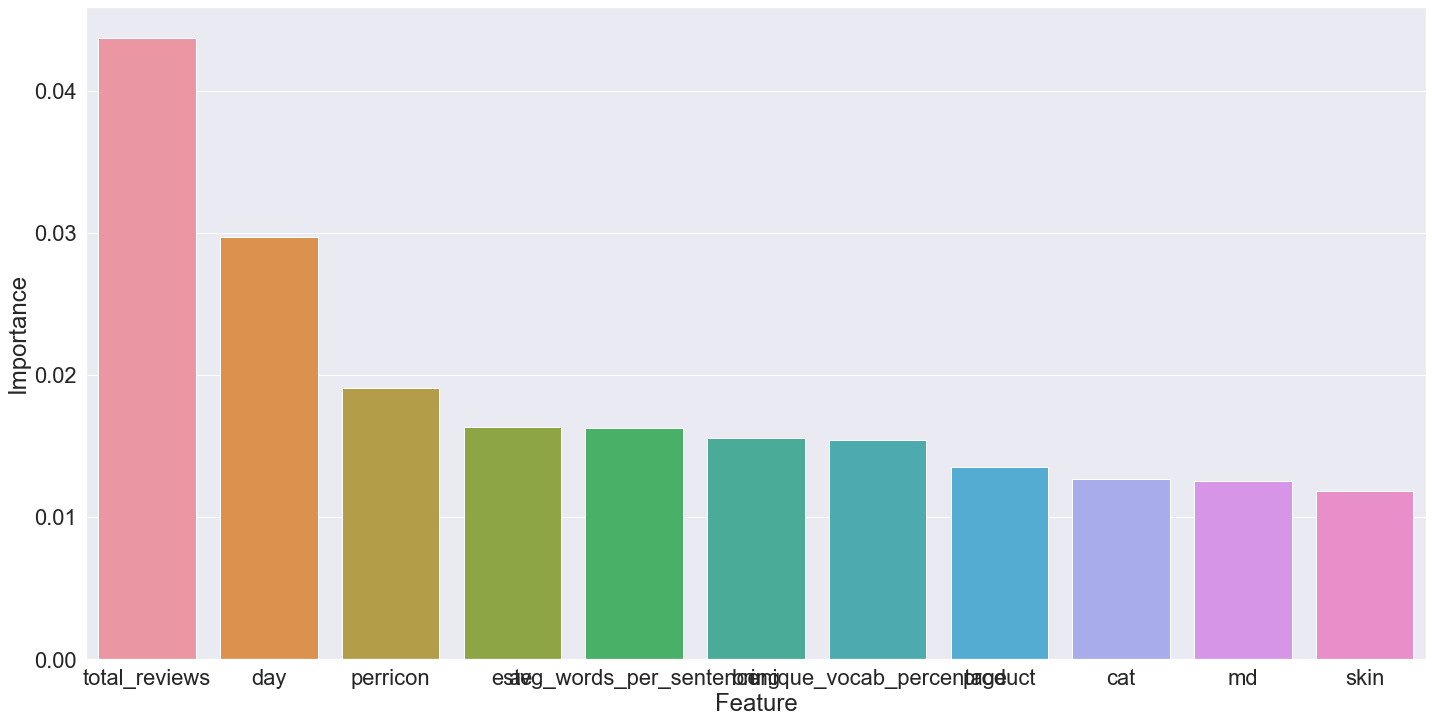

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(font_scale=2)
importances = pd.DataFrame({'Feature':x_train.columns, 'Importance':RF_model.feature_importances_})
importances = importances.sort_values('Importance', ascending=False).iloc[:11] 
plt.figure(figsize=(24,12))
graph = sns.barplot(x=importances['Feature'], y=importances['Importance'], data=importances)
#graph.set_xticklabels(graph.get_xticklabels(), rotation=90) # rotate x-axis labels

### Method 2: Without TF-IDF
From the feature importance graph generated from the Random Forest model, we find that the most important features are mostly not word frequency, so we try running random forest model using the original features without tfidf. 

In [59]:
df_decollete_simplified = pd.DataFrame()
df_decollete_simplified = normalization(df_decollete,df_decollete_simplified)

In [60]:
df_decollete_simplified

,total_reviews,review_rating,free_product,recommendation,have_title,len_of_review,avg_chars_per_word,avg_words_per_sentence,unique_vocab_percentage,information_integrity,fake_review
0,0.072797,1.00,0.0,0.0,1.0,0.076455,0.252269,0.175407,0.438627,0.000000,1.0
1,0.072797,1.00,0.0,0.0,1.0,0.080799,0.273253,0.117300,0.499832,0.000000,1.0
2,0.072797,1.00,0.0,0.0,1.0,0.066030,0.423077,0.291139,0.647866,0.666667,1.0
3,0.072797,1.00,0.0,0.0,1.0,0.029540,0.314633,0.167370,0.588147,0.666667,1.0
4,0.072797,0.25,0.0,0.0,0.0,0.017376,0.532967,0.156118,0.608740,0.666667,1.0
...,...,...,...,...,...,...,...,...,...,...,...
860,0.329502,1.00,0.0,1.0,1.0,0.033884,0.308715,0.316456,0.781622,0.666667,0.0
861,0.000000,0.25,0.0,0.0,1.0,0.032146,0.240150,0.184248,0.770970,0.666667,0.0
862,0.007663,1.00,0.0,0.0,1.0,0.023458,0.246721,0.084388,0.747574,0.666667,0.0
863,0.007663,0.00,0.0,0.0,1.0,0.020851,0.128728,0.111111,0.720528,0.666667,0.0


In [61]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_decollete_simplified, test_size = 0.3)
x_train = train.iloc[0:,0:-1]  
y_train = train.iloc[0:,-1]
x_test = test.iloc[0:,0:-1]
y_test = test.iloc[0:,-1]

In [62]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators=10)
RF_model.fit(x_train,np.ravel(y_train))
RF_y_pred = RF_model.predict(x_test)
RF_accuracy = np.average(RF_y_pred==y_test)
print(RF_accuracy)

0.9307692307692308


[Text(0, 0, 'total_reviews'),
 Text(0, 0, 'avg_chars_per_word'),
 Text(0, 0, 'avg_words_per_sentence'),
 Text(0, 0, 'len_of_review'),
 Text(0, 0, 'unique_vocab_percentage'),
 Text(0, 0, 'information_integrity'),
 Text(0, 0, 'review_rating'),
 Text(0, 0, 'recommendation'),
 Text(0, 0, 'have_title'),
 Text(0, 0, 'free_product')]

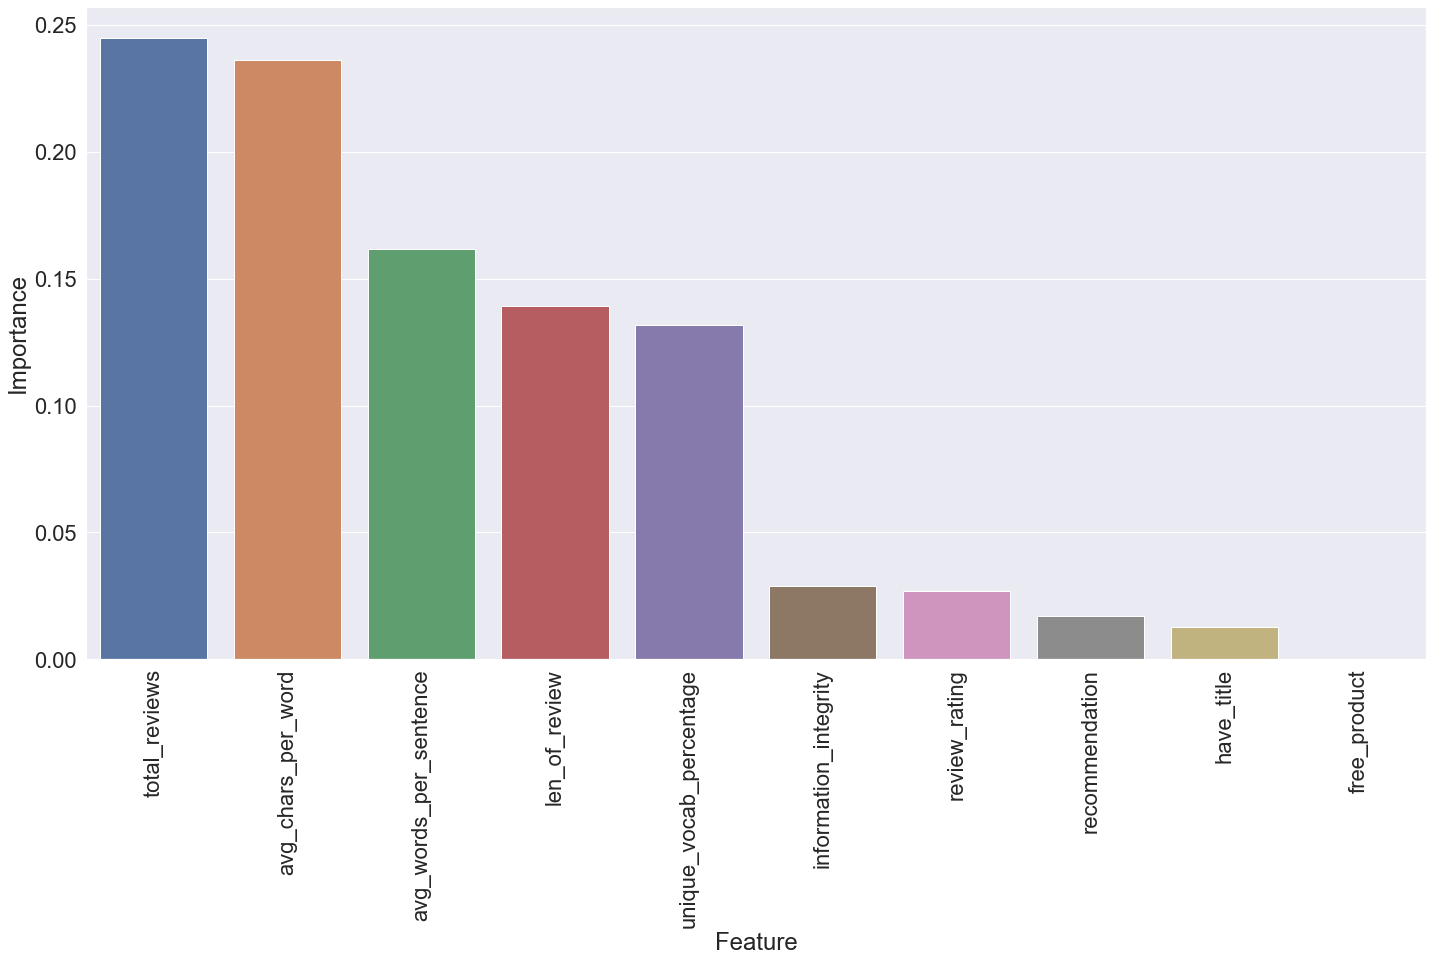

In [68]:
sns.set(font_scale=2)
importances = pd.DataFrame({'Feature':x_train.columns, 'Importance':RF_model.feature_importances_})
importances = importances.sort_values('Importance', ascending=False).iloc[:11] 
plt.figure(figsize=(24,12))
graph = sns.barplot(x=importances['Feature'], y=importances['Importance'], data=importances)
graph.set_xticklabels(graph.get_xticklabels(), rotation=90) # rotate x-axis labels

### Conclusion
From the accuracy results, we can see that the model using original features and the model using tfidf features both have 0.9 accuracy. The reason may be tfidf generates thousouds of features (frequency of all vocabulary), while most of them have limited predictive power. Since using tfidf method is too time consuming and space consuming, we choose to use the original features without tfidf as the features for the large Moiturizer dataset to run machine learning models.

# Machine Learning Models

In [19]:
df_all_moisturizer = add_features(df_all_moisturizer)
df_all_moisturizer_for_models = pd.DataFrame()
df_all_moisturizer_for_models = normalization(df_all_moisturizer,df_all_moisturizer_for_models)

In [20]:
df_all_moisturizer

,item_id,total_reviews,user_name,skin_type,skin_tone,age_range,review_title,review,review_rating,not_helpful,helpful,free_product,recommend,review_time,category,no_of_reviews,multiple,title_and_review,brand,mentions,counts,fake,have_title,len_of_review,avg_chars_per_word,avg_words_per_sentence,unique_vocab_percentage,information_integrity
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1932201,580,zombified,1,1,0,you'll get hooked!,i've heard so many great things about this--t...,5,220,2278,0,1,7 Sep 2017,moisturizer,1.0,0,you'll get hooked! i've heard so many great th...,la mer,la mer,3.0,1,1,305,4.403279,16.944444,0.544262,2
1,1932201,580,Stripper,1,1,0,good but not 170 dollars per ounce good,good? yes! 170 dollars per ounce good? not qu...,4,70,403,0,1,30 Apr 2018,moisturizer,1.0,0,good but not 170 dollars per ounce good good? ...,la mer,la mer,1.0,0,1,245,4.481633,20.416667,0.555102,2
2,1932201,580,alephbet,1,1,1,unbelievable!,i have rosacea and had been using first aid s...,5,60,394,0,0,22 Mar 2017,moisturizer,1.0,0,unbelievable! i have rosacea and had been usin...,la mer,la mer,1.0,0,1,122,4.581967,13.555556,0.655738,3
3,1932201,580,ShelbyWW,1,1,0,,got a free sample size and unfortunately it's...,5,38,367,0,1,12 Sep 2018,moisturizer,1.0,0,got a free sample size and unfortunately it'...,la mer,NaN,0.0,0,0,10,5.400000,10.000000,1.000000,2
4,1932201,580,meshybelle,1,1,1,worth it.,pricey? you betcha! worth it? yup!! my skin h...,5,52,347,0,0,23 May 2017,moisturizer,1.0,0,worth it. pricey? you betcha! worth it? yup!! ...,la mer,NaN,0.0,0,1,280,4.500000,11.200000,0.528571,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237294,1809235,51,Goldilocks55,1,1,0,disappointed,i bought this because other reviews said it w...,1,2,0,0,0,16 Jul 2019,moisturizer,1.0,0,disappointed i bought this because other revie...,dr. dennis gross skincare,NaN,0.0,0,1,71,4.605634,14.200000,0.746479,2
237295,1809235,51,SandyG19,1,1,0,great tinted moisturizer with spf.,i really like this product for its spf proper...,4,0,0,0,1,25 Apr 2019,moisturizer,1.0,0,great tinted moisturizer with spf. i really li...,dr. dennis gross skincare,NaN,0.0,0,1,132,4.863636,14.666667,0.621212,2
237296,1809235,51,ZeniZen,1,1,0,,this is great to layer over a tinted cream fo...,5,0,0,0,1,11 Oct 2017,moisturizer,1.0,0,this is great to layer over a tinted cream f...,dr. dennis gross skincare,NaN,0.0,0,0,16,4.625000,16.000000,1.000000,2


In [21]:
df_all_moisturizer_for_models

,total_reviews,review_rating,free_product,recommendation,have_title,len_of_review,avg_chars_per_word,avg_words_per_sentence,unique_vocab_percentage,information_integrity,fake_review
0,0.079972,1.00,0.0,1.0,1.0,0.254820,0.035774,0.038984,0.496290,0.666667,1.0
1,0.079972,0.75,0.0,1.0,1.0,0.204526,0.036646,0.047474,0.508271,0.666667,0.0
2,0.079972,1.00,0.0,0.0,1.0,0.101425,0.037763,0.030698,0.619500,1.000000,0.0
3,0.079972,1.00,0.0,1.0,0.0,0.007544,0.046872,0.022005,1.000000,0.666667,0.0
4,0.079972,1.00,0.0,0.0,1.0,0.233864,0.036850,0.024939,0.478947,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
220696,0.006906,0.00,0.0,0.0,1.0,0.058676,0.038027,0.032274,0.719792,0.666667,0.0
220697,0.006906,0.75,0.0,1.0,1.0,0.109807,0.040899,0.033415,0.581340,0.666667,0.0
220698,0.006906,1.00,0.0,1.0,0.0,0.012573,0.038242,0.036675,1.000000,0.666667,0.0
220699,0.006906,0.25,0.0,0.0,1.0,0.038558,0.034837,0.026284,0.647256,0.666667,0.0


In [22]:
train, test = train_test_split(df_all_moisturizer_for_models, test_size = 0.3)
x_train = train.iloc[0:,0:-1]  
y_train = train.iloc[0:,-1]
x_test = test.iloc[0:,0:-1]
y_test = test.iloc[0:,-1]

### Model 1: Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
LG_model = LogisticRegression()
LG_model.fit(x_train,y_train)
LG_y_pred  = LG_model.predict(x_test)
LG_accuracy = np.average(LG_y_pred==y_test)
print(LG_accuracy)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8993369681774932


### Model 2: Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators=10)
RF_model.fit(x_train,np.ravel(y_train))
RF_y_pred = RF_model.predict(x_test)
RF_accuracy = np.average(RF_y_pred==y_test)
print(RF_accuracy)

0.9202247360710456


### Model 3: Bagging

In [25]:
from sklearn.ensemble import BaggingClassifier
BG_model = BaggingClassifier(n_estimators=30,max_samples=1.0,max_features=10)
BG_model.fit(x_train, np.ravel(y_train))
BG_y_pred = BG_model.predict(x_test)
BG_accuracy = np.average(BG_y_pred==y_test)
print(BG_accuracy)

0.9207080394496383


### Model 4: Neural Network

In [26]:
from sklearn.neural_network import MLPClassifier
NN_model = MLPClassifier(solver='adam', hidden_layer_sizes=(30,), max_iter = 500, activation='relu',learning_rate='invscaling')
NN_model.fit(x_train, y_train)
NN_y_pred = NN_model.predict(x_test)
NN_accuracy = np.average(NN_y_pred==y_test)
print(NN_accuracy)

0.9000770264759632


### Model 5: K Nearest Neighbors

In [27]:
from sklearn.neighbors import KNeighborsClassifier
KNN_model=KNeighborsClassifier(3) # n_neighbors=1,3,5
KNN_model.fit(x_train,y_train)
knn_y_pred=KNN_model.predict(x_test)
KNN_accuracy = np.average(knn_y_pred==y_test)
print(KNN_accuracy)

0.8868919061787316


### Model 6: Multinomial Naive Bayes

In [28]:
from sklearn.naive_bayes import MultinomialNB
NB_model=MultinomialNB(alpha=1) # alpha=0.5,1
NB_model.fit(x_train,y_train)
NB_y_pred=NB_model.predict(x_test)
NB_accuracy = np.average(NB_y_pred==y_test)
print(NB_accuracy)

0.8993671746386552


### Model 7: Linear Support Vector Machine

In [29]:
from sklearn.svm import LinearSVC
LinearSVM_model=LinearSVC(C=1000,loss="hinge",tol=1e-9,max_iter=10000)
    # tol=1e-9,1e-8,1e-5
    # max_iter=100, 1000, 10000
    # C = 1,10,100,1000
LinearSVM_model.fit(x_train,y_train)
LSVM_y_pred=LinearSVM_model.predict(x_test)
LSVM_accuracy = np.average(LSVM_y_pred==y_test)
print(LSVM_accuracy)

0.8993671746386552


### Feature Importance

[Text(0, 0, 'total_reviews'),
 Text(0, 0, 'avg_chars_per_word'),
 Text(0, 0, 'unique_vocab_percentage'),
 Text(0, 0, 'len_of_review'),
 Text(0, 0, 'avg_words_per_sentence'),
 Text(0, 0, 'review_rating'),
 Text(0, 0, 'information_integrity'),
 Text(0, 0, 'have_title'),
 Text(0, 0, 'free_product'),
 Text(0, 0, 'recommendation')]

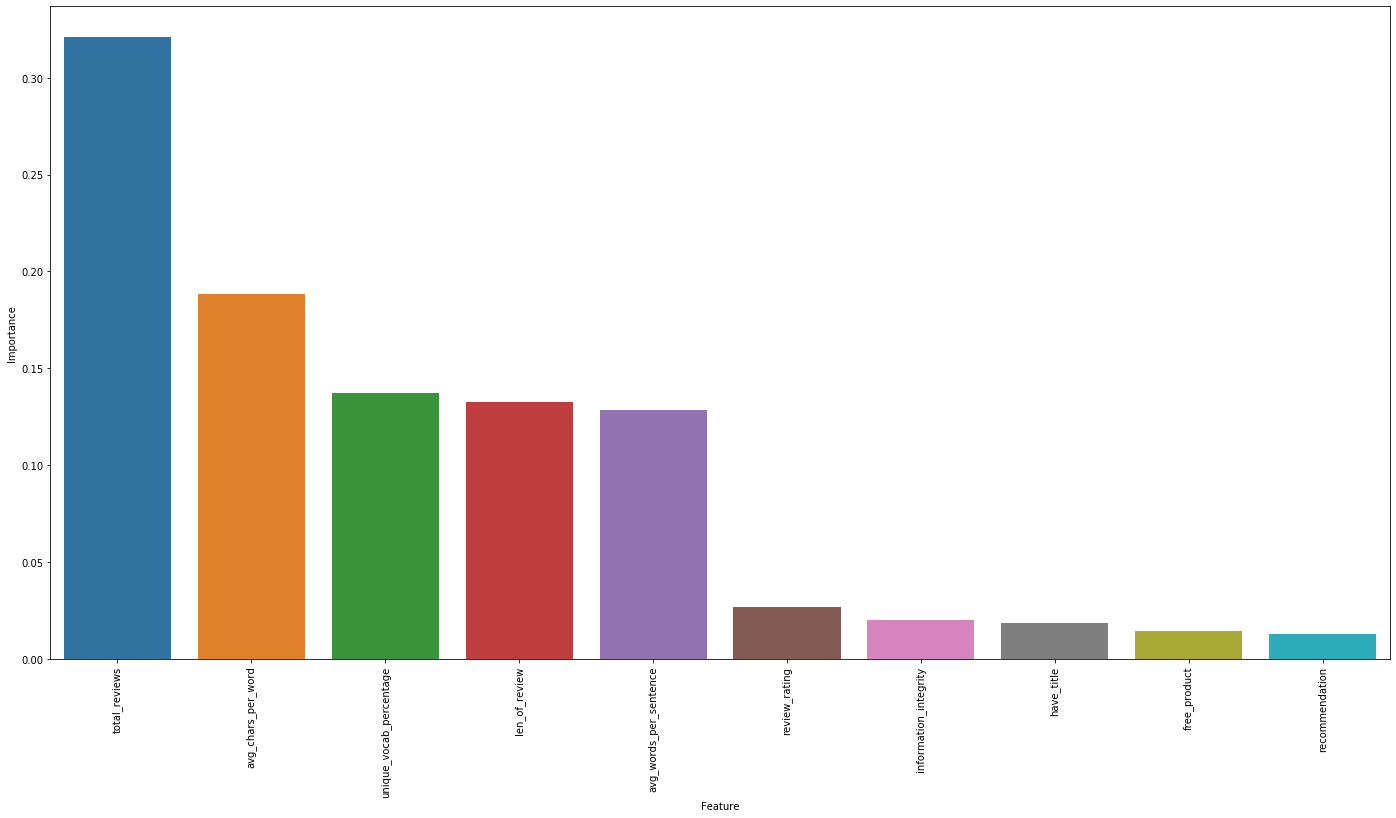

In [30]:
importances = pd.DataFrame({'Feature':x_train.columns, 'Importance':RF_model.feature_importances_})
importances = importances.sort_values('Importance', ascending=False).iloc[:21] 
plt.figure(figsize=(24,12))
graph = sns.barplot(x=importances['Feature'], y=importances['Importance'], data=importances)
graph.set_xticklabels(graph.get_xticklabels(), rotation=90) # rotate x-axis labels

### Model Comparison

In [31]:
!pip install plotly

In [34]:
import plotly.graph_objects as go

categories = ['Logistic Regression','Random Forest','Bagging','Neural Network','KNN',
              'Multinomial Naive Bayes','Linear SVM']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=[LG_accuracy,RF_accuracy,BG_accuracy,NN_accuracy,KNN_accuracy,NB_accuracy,LSVM_accuracy],
      theta=categories,
      name='Moisturizer'
    ,fill='toself'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0.8, 0.93]
    )),
  showlegend=False
)

fig.show()

### Conclusion
From the Radar graph, we can see that the Bagging model generates the highest accuracy. Using the predicted result from Bagging model, we are able to identify and relabel the fake reviews for all moisturizer products for further rerating process. Since we have scraped all skincare products besides the moisturizer category, you are free to use the model to identify fake reviews for other categories as well.

### Relabel fake reviews

In [42]:
df_all_moisturizer_for_models

,total_reviews,review_rating,free_product,recommendation,have_title,len_of_review,avg_chars_per_word,avg_words_per_sentence,unique_vocab_percentage,information_integrity,fake_review
0,0.079972,1.00,0.0,1.0,1.0,0.254820,0.035774,0.038984,0.496290,0.666667,1.0
1,0.079972,0.75,0.0,1.0,1.0,0.204526,0.036646,0.047474,0.508271,0.666667,0.0
2,0.079972,1.00,0.0,0.0,1.0,0.101425,0.037763,0.030698,0.619500,1.000000,0.0
3,0.079972,1.00,0.0,1.0,0.0,0.007544,0.046872,0.022005,1.000000,0.666667,0.0
4,0.079972,1.00,0.0,0.0,1.0,0.233864,0.036850,0.024939,0.478947,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
220696,0.006906,0.00,0.0,0.0,1.0,0.058676,0.038027,0.032274,0.719792,0.666667,0.0
220697,0.006906,0.75,0.0,1.0,1.0,0.109807,0.040899,0.033415,0.581340,0.666667,0.0
220698,0.006906,1.00,0.0,1.0,0.0,0.012573,0.038242,0.036675,1.000000,0.666667,0.0
220699,0.006906,0.25,0.0,0.0,1.0,0.038558,0.034837,0.026284,0.647256,0.666667,0.0


In [43]:
df_all_moisturizer_for_models.groupby('fake_review').count()

,total_reviews,review_rating,free_product,recommendation,have_title,len_of_review,avg_chars_per_word,avg_words_per_sentence,unique_vocab_percentage,information_integrity
fake_review,,,,,,,,,,
0.0,198019,198019,198019,198019,198019,198019,198019,198019,198019,198019
1.0,22682,22682,22682,22682,22682,22682,22682,22682,22682,22682


In [35]:
x = df_all_moisturizer_for_models.iloc[0:,0:-1]  
y = df_all_moisturizer_for_models.iloc[0:,-1]

In [41]:
BG_model = BaggingClassifier(n_estimators=30,max_samples=1.0,max_features=10)
BG_model.fit(x,y)
BG_y_pred = BG_model.predict(x)

In [45]:
df_all_moisturizer.reset_index(inplace=True)

In [46]:
df_all_moisturizer['predicted_fake_reviews']= pd.Series(BG_y_pred)

In [47]:
df_all_moisturizer

,index,Unnamed: 0,item_id,total_reviews,user_name,skin_type,skin_tone,age_range,review_title,review,review_rating,not_helpful,helpful,free_product,recommend,review_time,category,no_of_reviews,multiple,title_and_review,brand,mentions,counts,fake,have_title,len_of_review,avg_chars_per_word,avg_words_per_sentence,unique_vocab_percentage,information_integrity,predicted_fake_reviews
0,0,0,1932201,580,zombified,1,1,0,you'll get hooked!,i've heard so many great things about this--t...,5,220,2278,0,1,7 Sep 2017,moisturizer,1.0,0,you'll get hooked! i've heard so many great th...,la mer,la mer,3.0,1,1,305,4.403279,16.944444,0.544262,2,1.0
1,1,1,1932201,580,Stripper,1,1,0,good but not 170 dollars per ounce good,good? yes! 170 dollars per ounce good? not qu...,4,70,403,0,1,30 Apr 2018,moisturizer,1.0,0,good but not 170 dollars per ounce good good? ...,la mer,la mer,1.0,0,1,245,4.481633,20.416667,0.555102,2,0.0
2,2,2,1932201,580,alephbet,1,1,1,unbelievable!,i have rosacea and had been using first aid s...,5,60,394,0,0,22 Mar 2017,moisturizer,1.0,0,unbelievable! i have rosacea and had been usin...,la mer,la mer,1.0,0,1,122,4.581967,13.555556,0.655738,3,0.0
3,3,3,1932201,580,ShelbyWW,1,1,0,,got a free sample size and unfortunately it's...,5,38,367,0,1,12 Sep 2018,moisturizer,1.0,0,got a free sample size and unfortunately it'...,la mer,NaN,0.0,0,0,10,5.400000,10.000000,1.000000,2,0.0
4,4,4,1932201,580,meshybelle,1,1,1,worth it.,pricey? you betcha! worth it? yup!! my skin h...,5,52,347,0,0,23 May 2017,moisturizer,1.0,0,worth it. pricey? you betcha! worth it? yup!! ...,la mer,NaN,0.0,0,1,280,4.500000,11.200000,0.528571,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220696,220696,237294,1809235,51,Goldilocks55,1,1,0,disappointed,i bought this because other reviews said it w...,1,2,0,0,0,16 Jul 2019,moisturizer,1.0,0,disappointed i bought this because other revie...,dr. dennis gross skincare,NaN,0.0,0,1,71,4.605634,14.200000,0.746479,2,0.0
220697,220697,237295,1809235,51,SandyG19,1,1,0,great tinted moisturizer with spf.,i really like this product for its spf proper...,4,0,0,0,1,25 Apr 2019,moisturizer,1.0,0,great tinted moisturizer with spf. i really li...,dr. dennis gross skincare,NaN,0.0,0,1,132,4.863636,14.666667,0.621212,2,0.0
220698,220698,237296,1809235,51,ZeniZen,1,1,0,,this is great to layer over a tinted cream fo...,5,0,0,0,1,11 Oct 2017,moisturizer,1.0,0,this is great to layer over a tinted cream f...,dr. dennis gross skincare,NaN,0.0,0,0,16,4.625000,16.000000,1.000000,2,0.0
220699,220699,237297,1809235,51,JJAmy,1,1,0,not really!,this product doesn't cover the skin well and ...,2,0,0,0,0,14 Oct 2019,moisturizer,1.0,0,not really! this product doesn't cover the ski...,dr. dennis gross skincare,NaN,0.0,0,1,47,4.319149,11.750000,0.680851,2,0.0


In [48]:
df_all_moisturizer.groupby('predicted_fake_reviews').count()

,index,Unnamed: 0,item_id,total_reviews,user_name,skin_type,skin_tone,age_range,review_title,review,review_rating,not_helpful,helpful,free_product,recommend,review_time,category,no_of_reviews,multiple,title_and_review,brand,mentions,counts,fake,have_title,len_of_review,avg_chars_per_word,avg_words_per_sentence,unique_vocab_percentage,information_integrity
predicted_fake_reviews,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,198517,198517,198517,198517,196899,198517,198517,198517,198517,198517,198517,198517,198517,198517,198517,198517,198517,196899,198517,198517,198517,21927,198517,198517,198517,198517,198517,198517,198517,198517
1.0,22184,22184,22184,22184,22079,22184,22184,22184,22184,22184,22184,22184,22184,22184,22184,22184,22184,22079,22184,22184,22184,5226,22184,22184,22184,22184,22184,22184,22184,22184


We can see that using the best Bagging model, we predict 22184 fake reviews, compared with 22682 reviews generated using the 7 criterias manually.

In [50]:
# df_all_moisturizer.to_csv('Relabeled_Moisturizer.csv')